# Assignment 4 

# Kaplan-Meier  

# Import Libraries 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Load in the dataset and preprocessing 

In [43]:
# Load the dataset
file_path = '../Data/RADCURE_Clinical_v04_20241219.xlsx'
df = pd.read_excel(file_path)


# Convert 'RT Start', 'Last FU', and 'Date of Death' columns to datetime
df['RT Start'] = pd.to_datetime(df['RT Start'], errors='coerce')
df['Last FU'] = pd.to_datetime(df['Last FU'], errors='coerce')
df['Date of Death'] = pd.to_datetime(df['Date of Death'], errors='coerce')

# Calculate survival time in days: Difference between 'RT Start' and 'Date of Death'
df['Time'] = (df['Date of Death'] - df['RT Start']).dt.days
df['Time'] = df['Time'].fillna((df['Last FU'] - df['RT Start']).dt.days)  # For censored patients

# Event indicator: '1' for event (death), '0' for censored
df['event'] = np.where(df['Status'] == 'Dead', 1, 0)

# Group by a feature (e.g., 'Treatment Type' or 'Age Group')
# Example: Grouping by 'Treatment Type'
group_1 = df[df['Tx Modality'] == 'ChemoRT']
group_2 = df[df['Tx Modality'] == 'RT alone']
group_3 = df[df['Tx Modality'] == 'RT + EGFRI']


# KM for treatment group 1 : ChemoRT

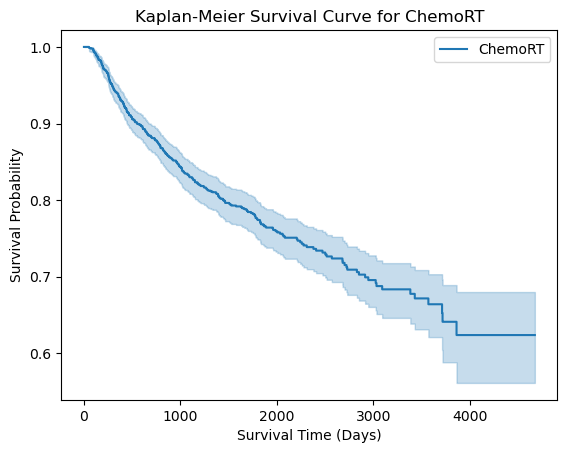

In [44]:
# Kaplan-Meier Estimation for Group 1
kmf1 = KaplanMeierFitter()
kmf1.fit(group_1['Time'], event_observed=group_1['event'], label='ChemoRT')
kmf1.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for ChemoRT')
plt.xlabel('Survival Time (Days)')
plt.ylabel('Survival Probability')
plt.show()


# KM for treatment group 2 : RT alone 

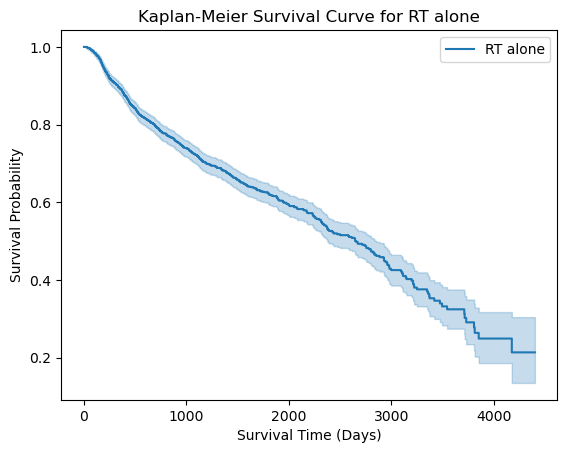

In [45]:
# Kaplan-Meier Estimation for Group 2
kmf2 = KaplanMeierFitter()
kmf2.fit(group_2['Time'], event_observed=group_2['event'], label='RT alone')
kmf2.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for RT alone')
plt.xlabel('Survival Time (Days)')
plt.ylabel('Survival Probability')
plt.show()

# KM for treatment group 3 : RT + EGFRI

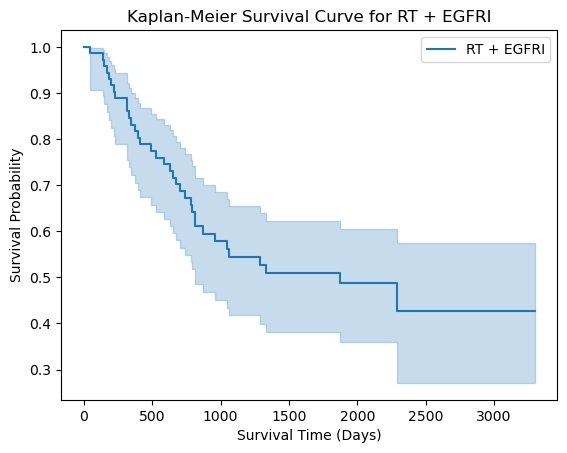

In [46]:
# Kaplan-Meier Estimation for Group 2
kmf3 = KaplanMeierFitter()
kmf3.fit(group_3['Time'], event_observed=group_3['event'], label='RT + EGFRI')
kmf3.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve for RT + EGFRI')
plt.xlabel('Survival Time (Days)')
plt.ylabel('Survival Probability')
plt.show()

# Log-rank tests for Groups 1 - 3 

In [47]:
# Log-rank test to compare survival between the two groups
results_1_2 = logrank_test(group_1['Time'], group_2['Time'], event_observed_A=group_1['event'], event_observed_B=group_2['event'])
print(f"Log-rank test p-value between group 1 and group 2: {results_1_2.p_value}")

results_1_3 = logrank_test(group_1['Time'], group_3['Time'], event_observed_A=group_1['event'], event_observed_B=group_3['event'])
print(f"Log-rank test p-value between group 1 and group 3: {results_1_3.p_value}")

results_2_3 = logrank_test(group_2['Time'], group_3['Time'], event_observed_A=group_2['event'], event_observed_B=group_3['event'])
print(f"Log-rank test p-value between group 2 and group 3: {results_2_3.p_value}")

Log-rank test p-value between group 1 and group 2: 1.6269114793850402e-27
Log-rank test p-value between group 1 and group 3: 3.949533205022451e-09
Log-rank test p-value between group 2 and group 3: 0.0387027659424085


# Cox proportional hazards regression

# load in necessary libraries 

In [48]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

# Data processing and preparation for Cox regression

In [49]:
# Check the number of events and censored data
event_counts = df['event'].value_counts()
print("Event counts:\n", event_counts)

# Check if there are events (1's) in the dataset
if 1 in event_counts.index:
    proportion_events = event_counts[1] / len(df)
    proportion_censored = event_counts[0] / len(df)
    print(f"Proportion of events: {proportion_events:.2f}")
    print(f"Proportion of censored: {proportion_censored:.2f}")
else:
    print("No events (deaths) in the dataset.")



Event counts:
 event
0    2288
1    1058
Name: count, dtype: int64
Proportion of events: 0.32
Proportion of censored: 0.68


In [ ]:
# Covariates: Age, Sex, Dose (replace with your actual covariates)
covariates = ['Age', 'Sex', 'Dose']

# One-hot encode categorical variables (e.g., 'Sex')
df_encoded = pd.get_dummies(df[covariates], drop_first=True)  # Drop the first category to avoid dummy variable trap

# Concatenate the encoded features with the original dataframe to preserve 'Time' and 'event' columns
X = pd.concat([df_encoded, df[['Time', 'event']]], axis=1)  # Keep original dataset for the PH test

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter(penalizer=0.1)  # Apply L1 regularization (Lasso)
cph.fit(X, duration_col='Time', event_col='event')

# Display the summary of the Cox model
cph.print_summary()

# Validate the proportional hazards assumption
# Pass the original dataframe (df) to the proportional hazard test function
results = proportional_hazard_test(cph, X, time_transform='rank')
print(f"Proportional Hazards assumption test p-value: {results.p_value}")



<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'Time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7882.78
         time fit was run = 2025-03-05 21:44:01 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age        0.03      1.03      0.00            0.03            0.04                1.03                1.04
Dose      -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
Sex_Male   0.01      1.01      0.07           -0.12            0.14                0.88                1.15

           cmp to     z      p  -log2(p)
covariate                               
Age          0.00 12.98 <0.005    125.56
Dose         0.00 -0.62   0.54      0.90
Sex_Male     0.00  0.13   0.90      0.15
---
Concordance = 0.62
Partial AIC = 15771.56
log-likelihood ratio test = 182.30 on 3 df
-log2(p) of ll-ratio test = 128.07

Proportional Hazards assumption test p-value: [0.0078748  0.00137224 0.06409276]


# Random Survival Forests Model

In [56]:
#load in packages and dependencies 

import pandas as pd
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sksurv.preprocessing import OneHotEncoder

C-index for Random Survival Forest: 0.5481842878527471


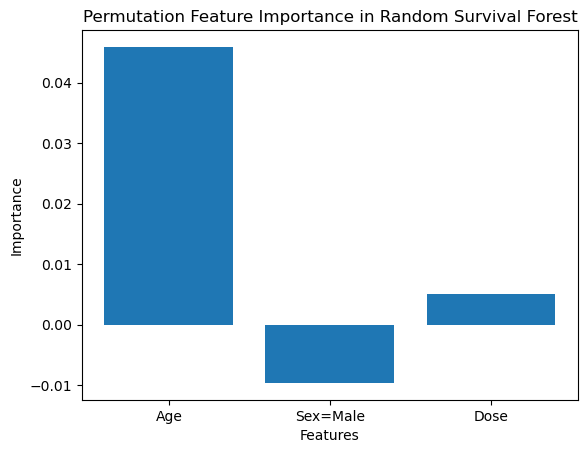

<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'Time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7850.78
         time fit was run = 2025-03-05 21:54:22 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age        0.04      1.05      0.00            0.04            0.05                1.04                1.05
Sex=Male   0.01      1.01      0.08           -0.14            0.16                0.87                1.17
Dose       0.00      1.00      0.01           -0.01            0.01                0.99                1.01

           cmp to     z      p  -log2(p)
covariate                               
Age          0.00 14.98 <0.005    166.21
Sex=Male     0.00  0.13   0.89      0.16
Dose         0.00  0.49   0.62      0.68
---
Concordance = 0.62
Partial AIC = 15707.57
log-likelihood ratio test = 246.30 on 3 df
-log2(p) of ll-ratio test = 174.02

C-index for Cox Proportional Hazards: 0.6218248583128807


In [ ]:
#Covariates: Age, Sex, Dose (replace with your actual covariates)
covariates = ['Age', 'Sex', 'Dose']

# Convert categorical variables (e.g., 'Sex') to 'category' dtype
df['Sex'] = df['Sex'].astype('category')

# One-hot encode categorical variables (e.g., 'Sex')
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df[covariates])

# Prepare the survival data
X = df_encoded  # Independent features (after encoding)
y = np.array([(row['event'], row['Time']) for index, row in df.iterrows()], dtype=[('event', 'bool'), ('time', 'f4')])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train, y_train)

# Evaluate the RSF model using the Concordance Index (C-index)
y_pred = rsf.predict(X_test)
c_index_rsf = concordance_index_censored(y_test['event'], y_test['time'], y_pred)
print(f"C-index for Random Survival Forest: {c_index_rsf[0]}")

# Perform permutation importance for Random Survival Forest
result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)

# Plot permutation importance
importances = result.importances_mean
plt.bar(encoder.get_feature_names_out(covariates), importances)
plt.title('Permutation Feature Importance in Random Survival Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# fit the Cox Proportional Hazards model for comparison
cph = CoxPHFitter()
df_cph = pd.concat([df[covariates], df[['Time', 'event']]], axis=1)  # Merge covariates with survival time and event
df_cph_encoded = pd.concat([df_encoded, df[['Time', 'event']]], axis=1)  # Add encoded covariates

cph.fit(df_cph_encoded, duration_col='Time', event_col='event')

# Display the summary of the Cox model
cph.print_summary()

# C-index for Cox Proportional Hazards model
c_index_cox = cph.concordance_index_
print(f"C-index for Cox Proportional Hazards: {c_index_cox}")